In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses
from sklearn.utils import shuffle
import numpy as np
import os
import cv2
import tensorflow.keras.backend as K
from tensorflow.keras.preproccessing.image import ImageDataGenerator
import wandb
from wandb.keras import WandbCallback

In [15]:
DATADIR = "data/Training/"
CATEGORIES = ["glioma_tumor","meningioma_tumor","no_tumor","pituitary_tumor"]
IMG_SIZE = 70
training_data = []

for category in CATEGORIES:
    path = os.path.join(DATADIR,category)
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
        new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
        training_data.append([new_array,class_num])



8
12.258627765806112
14.466409731812524
17.84369079550187
21.716256652320787
13.90625490526789
16.187181737849773
22.812918367346935
23.589896293211158
11.749233135124054
21.295948368306632
14.47825510204082
17.611737536617195
11.921190950798927
25.44969940002109
27.532741191170352
22.440943856726367
23.789519757023005
14.839216326530613
14.28966865636428
5.86412143442463
17.757847093066896
23.490314652176664
12.447967716376699
14.941361516034984
22.485675760099955
12.00083587188111
14.759324023124604
23.50838621407747
22.293087674873384
7.304267230600286
14.219369387755103
20.58118608912953
16.778654060808
15.394109760226025
17.611530204682257
18.596616201745924
22.53895918367347
23.121070387338612
37.26624741909543
18.80091611828405
25.928028696376508
13.760336653767492
9.91015899966544
11.707524999070664
14.243068212893098
25.207564444224293
25.241013385541915
13.776387734256113
19.964649826032108
10.599757811838431
16.08840291900163
20.644997084548105
37.51016713284299
18.768004084

In [3]:
DATADIR = "data/Testing/"
CATEGORIES = ["glioma_tumor","meningioma_tumor","no_tumor","pituitary_tumor"]
IMG_SIZE = 70
testing_data = []

for category in CATEGORIES:
    path = os.path.join(DATADIR,category)
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
        new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
        testing_data.append([new_array,class_num])


In [19]:
wandb.login()

config = {
    "epochs": 10,
    "batch_size": 32,
    "dropout": 0,
    "loss_function": "sparse_categorical_crossentropy",
    "optimizer": "Adam",
    "dataset": "wine quality"
}

run = wandb.init(project='test', entity='pepe_raider')
wandb.config.update(config)

wandb: wandb version 0.10.24 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [20]:
test_X = []
test_y = []

for image, label in testing_data:
    test_X.append(image)
    test_y.append(label)

test_X = np.array(test_X).reshape(-1,IMG_SIZE,IMG_SIZE)
test_X = test_X/255.0 
test_X = test_X.reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = np.array(test_y)

test_X, test_y = shuffle(test_X, test_y)

In [21]:
train_X = []
train_y = []

for image, label in training_data:
    train_X.append(image)
    train_y.append(label)

train_X = np.array(train_X).reshape(-1,IMG_SIZE,IMG_SIZE)
train_X = train_X/255.0
train_X = train_X.reshape(-1,IMG_SIZE,IMG_SIZE,1)
train_y = np.array(train_y)

train_X, train_y = shuffle(train_X, train_y)

In [22]:
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [23]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(70, 70, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(4, activation = "softmax"))

model.compile(optimizer='adam',
              loss=losses.SparseCategoricalCrossentropy(),
              metrics=[get_f1, 'accuracy'])

my_callbacks = [
    WandbCallback(monitor='val_loss', mode='min', save_model=True)
]

history = model.fit(train_X, train_y, batch_size=config['batch_size'], epochs=config['epochs'], validation_split=0.2, callbacks=my_callbacks)

Epoch 1/10
72/72 [==============================] - 3s 47ms/step - loss: 1.0125 - get_f1: 1.7941 - accuracy: 0.5557 - val_loss: 0.7879 - val_get_f1: 1.2337 - val_accuracy: 0.6812
Epoch 2/10
72/72 [==============================] - 4s 54ms/step - loss: 0.6873 - get_f1: 1.0869 - accuracy: 0.7143 - val_loss: 0.6433 - val_get_f1: 1.0597 - val_accuracy: 0.7178
Epoch 3/10
72/72 [==============================] - 3s 46ms/step - loss: 0.5097 - get_f1: 0.9909 - accuracy: 0.7992 - val_loss: 0.5453 - val_get_f1: 0.9783 - val_accuracy: 0.7753
Epoch 4/10
72/72 [==============================] - 3s 46ms/step - loss: 0.4170 - get_f1: 0.9452 - accuracy: 0.8406 - val_loss: 0.4694 - val_get_f1: 0.9298 - val_accuracy: 0.8310
Epoch 5/10
72/72 [==============================] - 3s 46ms/step - loss: 0.3244 - get_f1: 0.9284 - accuracy: 0.8802 - val_loss: 0.4245 - val_get_f1: 0.8900 - val_accuracy: 0.8449
Epoch 6/10
72/72 [==============================] - 3s 46ms/step - loss: 0.2563 - get_f1: 0.9012 - accura

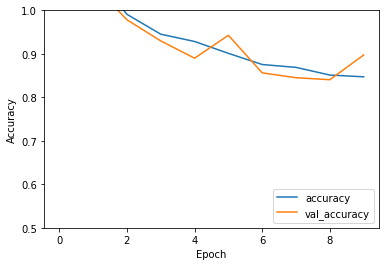

In [24]:
plt.plot(history.history['get_f1'], label='accuracy')
plt.plot(history.history['val_get_f1'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [25]:
y_pred = model.predict(test_X)
y_pred = np.argmax(y_pred,axis=1)

In [26]:
from sklearn.metrics import classification_report,confusion_matrix

clf_report = classification_report(test_y,y_pred)
print(clf_report)

              precision    recall  f1-score   support

           0       0.68      0.13      0.22       100
           1       0.65      0.89      0.75       115
           2       0.61      0.94      0.74       105
           3       0.88      0.66      0.75        74

    accuracy                           0.67       394
   macro avg       0.71      0.66      0.62       394
weighted avg       0.69      0.67      0.61       394



In [27]:

wandb.log({'Test report': clf_report})
run.finish()


Run pip install nbformat to save notebook history


epoch,9
loss,0.10228
get_f1,0.84718
accuracy,0.96124
val_loss,0.48649
val_get_f1,0.89739
val_accuracy,0.83972
_runtime,56
_timestamp,1617646575
_step,10
best_val_loss,0.42232


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▃▂▂▁▁▁
get_f1,█▃▂▂▂▁▁▁▁▁
accuracy,▁▄▅▆▇▇▇███
val_loss,█▅▃▂▁▁▁▂▄▂
val_get_f1,█▅▃▃▂▃▁▁▁▂
val_accuracy,▁▂▄▇▇▆█▇▇▇
_runtime,▁▂▂▃▃▄▄▄▅▅█
_timestamp,▁▂▂▃▃▄▄▄▅▅█
_step,▁▂▂▃▄▅▅▆▇▇█


In [ ]:
# plt.style.use("ggplot")
# plt.figure(figsize=(12,6))
# epochs = range(1,16)
# plt.subplot(1,2,1)
# plt.plot(epochs,history.history["accuracy"],'go-')
# plt.plot(epochs,history.history["val_accuracy"],'ro-')
# plt.title("Model Accuracy")
# plt.xlabel("Epochs")
# plt.ylabel("Accuracy")
# plt.legend(['Train','Val'],loc = "upper left")

# plt.subplot(1,2,2)
# plt.plot(epochs,history.history["loss"],'go-')
# plt.plot(epochs,history.history["val_loss"],'ro-')
# plt.title("Model Loss")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.legend(['Train','Val'],loc = "upper left")

# plt.show()